### Actividad Programación Aprendizaje Supervisado
### Briam Sebastian Ramos Guevara
### Grupo A

#### 0) Lectura de datos

In [72]:
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
from scipy.ndimage import binary_fill_holes as bfh
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
import pytesseract

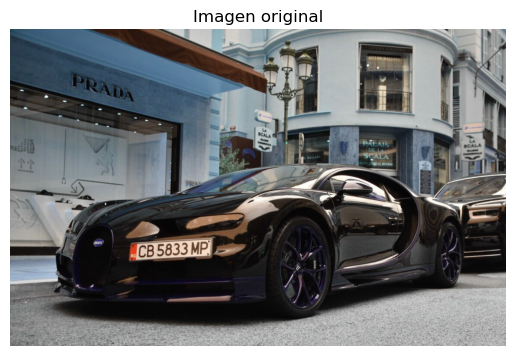

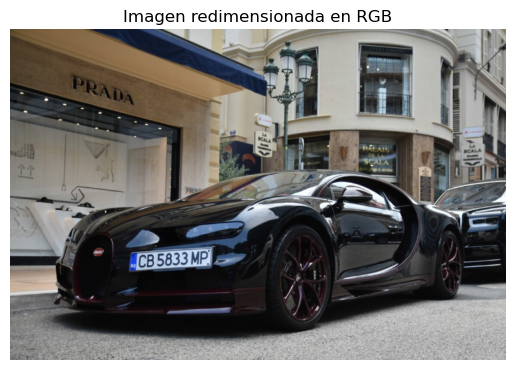

In [73]:
# Cargar la imagen 'auto_1.jpg' con opencv
ruta_imagen = 'auto_1.jpg'
imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
# Convertir la imagen a formato RGB
img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
# Redimensionar la imagen mediante el método de opencv "resize()" a un tamaño de (768,512)
imagen_redimensionada = cv2.resize(img_rgb, (768, 512))
# Visualizar la imagen
plt.imshow(imagen)
plt.axis('off') 
plt.title("Imagen original")
plt.show()

plt.imshow(imagen_redimensionada)
plt.axis('off') 
plt.title("Imagen redimensionada en RGB")
plt.show()

#### 1) Detección de bordes con Canny

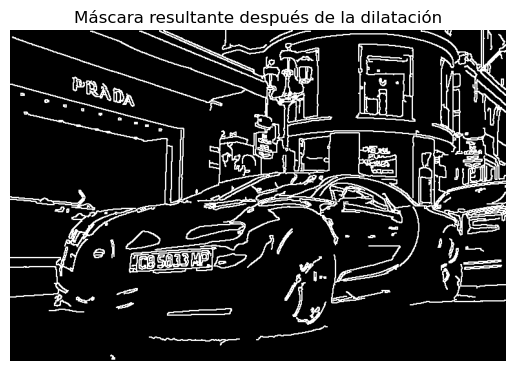

In [74]:
# Aplicar un filtro gaussiano con un kernel de 3x3
imagen_gauss = cv2.GaussianBlur(imagen_redimensionada, (3, 3), 0)
# Escala de grises
img_gray = cv2.cvtColor(imagen_gauss, cv2.COLOR_BGR2GRAY)
# Binarizar
_, threshold_img = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
# Aplicar el método de Canny para la detección de bordes
bordes = cv2.Canny(imagen_gauss, 255/3, 255)
# Aplicar una dilatación con un kernel de 2x2 y 1 iteración
kernel = np.ones((2, 2), np.uint8)
mascara_dilatada = cv2.dilate(bordes, kernel, iterations=1)
# Visualizar la máscara resultante
plt.imshow(mascara_dilatada, cmap='gray')
plt.axis('off')
plt.title("Máscara resultante después de la dilatación")
plt.show()

#### 2) Procesamiento mediante operaciones morfológicas

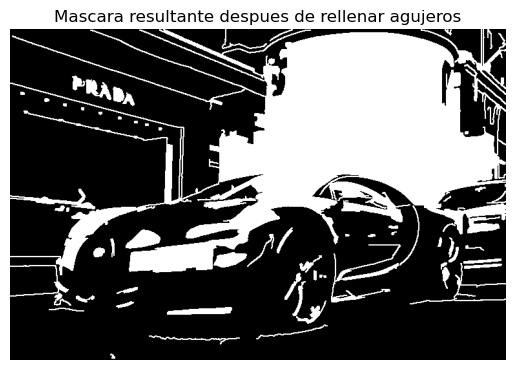

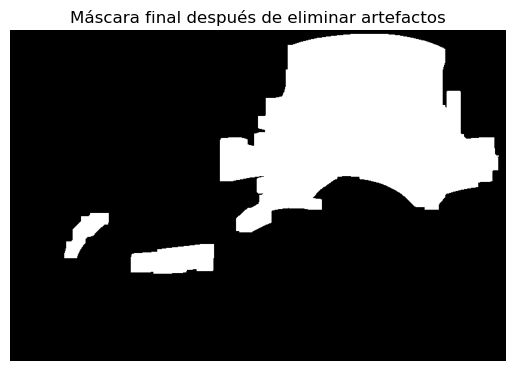

In [75]:
# Aplicar el comando "binary_fill_holes" sobre los bordes detectados.
# Nota: convertir la imagen a formato "uint8"
filled_bordes = bfh(mascara_dilatada > 0).astype(np.uint8) * 255
plt.imshow(filled_bordes, cmap='gray')
plt.axis('off')
plt.title('Mascara resultante despues de rellenar agujeros')
plt.show()
# Aplicar una apertura en el eje vertical con un kernel de 20x1 y 1 iteración para eliminar bordes verticales. 
# Nota: Aplicar el método de opencv "mophologyEx()" con cv2.MORPH_OPEN. 
apertura_vertical = np.ones((20, 1), np.uint8)
mascara_apertura_vertical = cv2.morphologyEx(filled_bordes, cv2.MORPH_OPEN, apertura_vertical, iterations=1)
# Aplicar una apertura en el eje horizontal con un kernel de 1x20 y 1 iteración para eliminar bordes horizontales
apertura_horizontal = np.ones((1, 20), np.uint8)
mascara_apertura_horizontal = cv2.morphologyEx(mascara_apertura_vertical, cv2.MORPH_OPEN, apertura_horizontal, iterations=1)
# Eliminar artefactos, es decir, objetos cuya área tenga menos de 1000 píxeles con una connectivity=8.  
# Nota: utilizar el método "remove_small_objects()" sobre la máscara anterior en formato booleano. 
mascara_boolean = mascara_apertura_horizontal > 0
mascara_sin_artefactos = remove_small_objects(mascara_boolean, min_size=1000, connectivity=2)
# Convertir la máscara resultante a formato uint8
mascara_final = (mascara_sin_artefactos.astype(np.uint8)) * 255
# Visualizar la máscara resultante
plt.imshow(mascara_final, cmap='gray')
plt.axis('off')
plt.title("Máscara final después de eliminar artefactos")
plt.show()

#### 3) Detección automática de la región de interés correspondiente a la matrícula

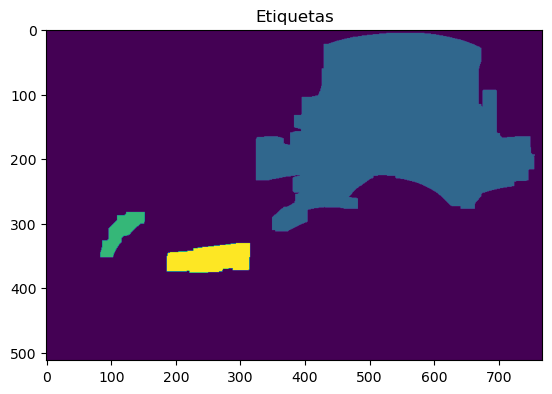

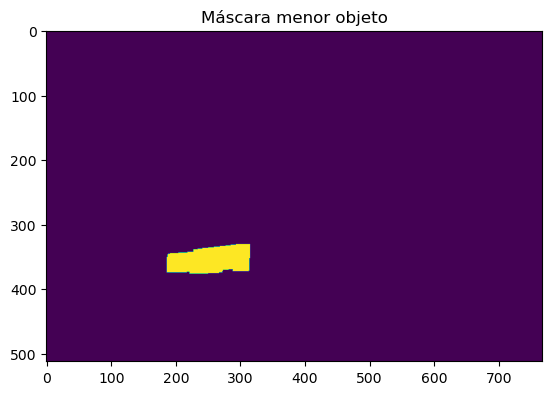

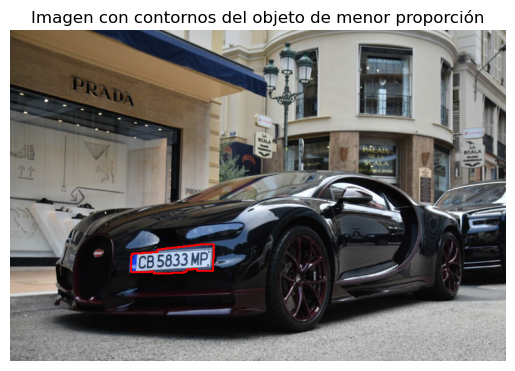

In [76]:
# Crear una imagen de etiquetas mediante el comando "label"
etiquetas = label(mascara_final, connectivity=2)
plt.imshow(etiquetas)
plt.title('Etiquetas')
plt.show()
# Calcular la proporción (cociente) entre el minor_axis_length y el major_axis_length para cada objeto de la imagen de etiquetas
regiones = regionprops(etiquetas)
proporciones = [(region.minor_axis_length / region.major_axis_length, region.label) for region in regiones if region.major_axis_length > 0]
# Generar una máscara que contenga únicamente el objeto de la menor proporción. 
menor_proporcion = min(proporciones, key=lambda x: x[0])
etiqueta_menor = menor_proporcion[1]
    
mascara_menor_objeto = (etiquetas == etiqueta_menor).astype(np.uint8) * 255
plt.imshow(mascara_menor_objeto)
plt.title('Máscara menor objeto')
plt.show()
    
# Dibujar los contornos de la máscara sobre la imagen original y visualizar el resultado
contornos, _ = cv2.findContours(mascara_menor_objeto, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imagen_con_contornos = imagen_redimensionada.copy()
cv2.drawContours(imagen_con_contornos, contornos, -1, (255, 0, 0), 2)  # Contornos en rojo

plt.imshow(imagen_con_contornos)
plt.axis('off')
plt.title("Imagen con contornos del objeto de menor proporción")
plt.show()

#### 4) Procesamiento de la región de interés

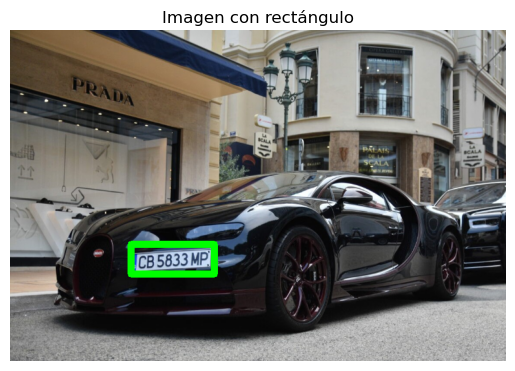

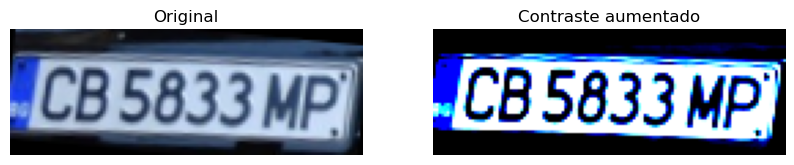

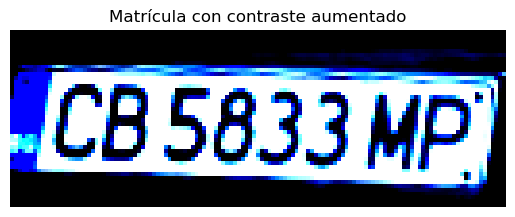

In [77]:
# Calcular la boundingbox de la máscara
prop = regionprops(etiquetas, intensity_image=imagen_redimensionada)[etiqueta_menor - 1]
bbox = prop.bbox

# Extraer los puntos para el rectángulo ajustado
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])

# Dibujar el rectángulo ajustado sobre la imagen
imagen_con_rectangulo = cv2.rectangle(imagen_redimensionada.copy(), start_point, end_point, (0, 255, 0), 10)

# Mostrar la imagen con el rectángulo
plt.imshow(imagen_con_rectangulo)
plt.axis('off')
plt.title("Imagen con rectángulo")
plt.show()

# Hacer un crop de la imagen original a partir de las coordenadas de la boundingbox
crop_imagen = imagen_redimensionada[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Calcular la orientación de la máscara. 
orientation = prop.orientation
# Hacer una conversión mediante la siguiente fórmula:
    # angle = (orientation*90)/(math.pi/2). Nota: utilizar "import math"
    # Si 'angle' es mayor que 0, la orientación será igual a 90-angle
    # Si no, la orientación será igual a -(90+angle)
angle = (orientation * 90) / (math.pi / 2)
if angle > 0:
    angle = 90 - angle
else:
    angle = -(90 + angle)
# Aplicar una transformación geométrica de rotación para orientar horizontalmente el crop de la imagen obtenido anteriormente
rows, cols, _ = crop_imagen.shape
M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
crop_imagen = cv2.warpAffine(crop_imagen, M, (cols, rows))

# Aumentar el contraste 100 unidades de acuerdo a la fórmula vista en clase. 

contraste = 100

f = 131 * (contraste + 127) / (127 * (131 - contraste))
alpha_c = f
gamma_c = 127 * (1 - f)

# Aplicar la corrección de contraste
contrast_img = cv2.addWeighted(crop_imagen, alpha_c, crop_imagen, 0, gamma_c)

# Mostrar las imágenes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_imagen, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(contrast_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Contraste aumentado')
ax[1].axis('off')
plt.show()

# Visualizar el resultado la matrícula con el contraste aumentado
plt.imshow(contrast_img)
plt.axis('off')  
plt.title("Matrícula con contraste aumentado")
plt.show()

#### 5) Convertir el contenido de la imagen en un string mediante la librería 'pytesseract'
Para instalar la librería pytesseract:
    
    Descargar el ejecutable en -->  https://github.com/UB-Mannheim/tesseract/wiki
    Instalar la librería haciendo --> pip install pytesseract

Si se tienen dudas, consultar el siguiente vídeo:

    https://www.youtube.com/watch?v=_j6o2rBkhhg

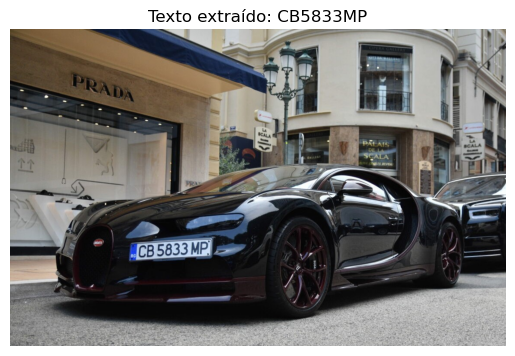

In [78]:
# Crear la ruta de pytesseract que contenga el ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
# Convertir el contenido de la imagen en una variable de tipo string.
# Importante: utiliza la opción --> config='--psm 10'
texto_extraido = pytesseract.image_to_string(contrast_img, config='--psm 10')
# Eliminar del string los caracteres especiales mediante la siguiente línea de código:
# string = ''.join(filter(str.isalnum, string))
without_caracs = ''.join(filter(str.isalnum, texto_extraido))
# Visualizar la imagen original y ponle el título extraído automáticamente mediante la librería "pytesseract"
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Texto extraído: {without_caracs}")
plt.show()